In [1]:
#--- Load necessary libraries
library(data.table)
library(BSgenome.Hsapiens.UCSC.hg38)
library(GenomicRanges)
library(GenomicFeatures)
library(plyr)
library(mixtools)
options(warn=1) # print any warnings
colscheme = c("deeppink","darkgreen","dodgerblue","grey")

Loading required package: BSgenome
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: IRanges

Atta

## Check for ./tsg_annotation.rda

In [1]:
if(file.exists("./tsg_annotation.rda")) {
    cat("TSG annotation data file exists\n")
} else {
    cat("TSG annotation must be created (tsg_insertionstats_v2.ipynb)")
}

TSG annotation data file exists


## Analysis 3 - TSGs are ranked by enriched EN site counts

For the plots below, the TSG 'count rank' is computed by first multiplying the count for each S-V site category by its respective enrichment factor, then taking the sum over the 4 categories.

In [3]:
load("./tsg_annotation.rda")

tsg_counts_enrich <- t( t(tsg_counts) * c(11.55,7.25,1.95,1.00) )
rank_den <- rowSums(tsg_counts_enrich)/tsgann$length # calculate density of EN sites of each TSG
rownames(tsg_counts) <- tsgann$tsg_name

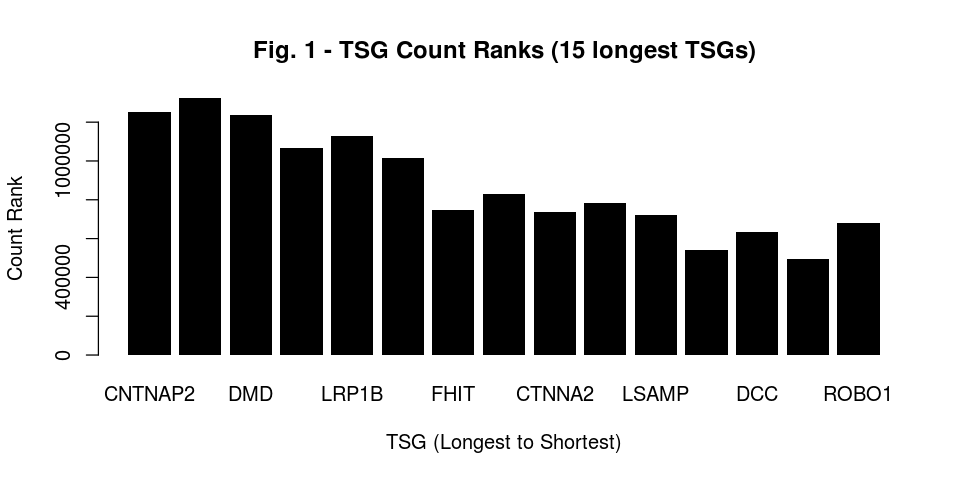

In [59]:
barplot(rowSums(tsg_counts_enrich[1:15,]),col=c("black"),ylab="Count Rank",xlab="TSG (Longest to Shortest)",border=NA)
title("Fig. 1 - TSG Count Ranks (15 longest TSGs)")
options(repr.plot.width=8, repr.plot.height=4)

The TSG 'density rank' is simply the count rank normalized by the length of the TSG.

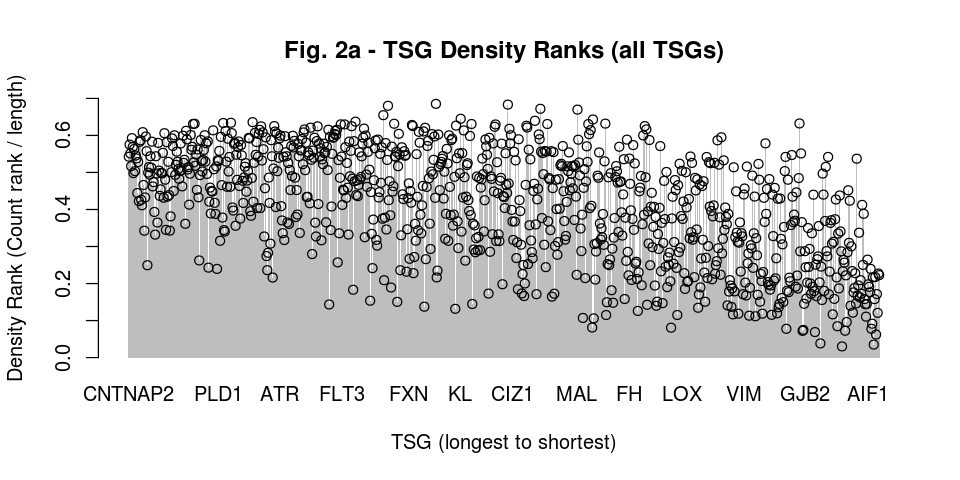

In [57]:
bar <- barplot(rank_den,ylab="Density Rank (Count rank / length)",xlab="TSG (longest to shortest)",col="grey",border=NA,space=0,ylim=c(0,.7))
title("Fig. 2a - TSG Density Ranks (all TSGs)")
points(x=bar,rank_den)
options(repr.plot.width=8, repr.plot.height=4)

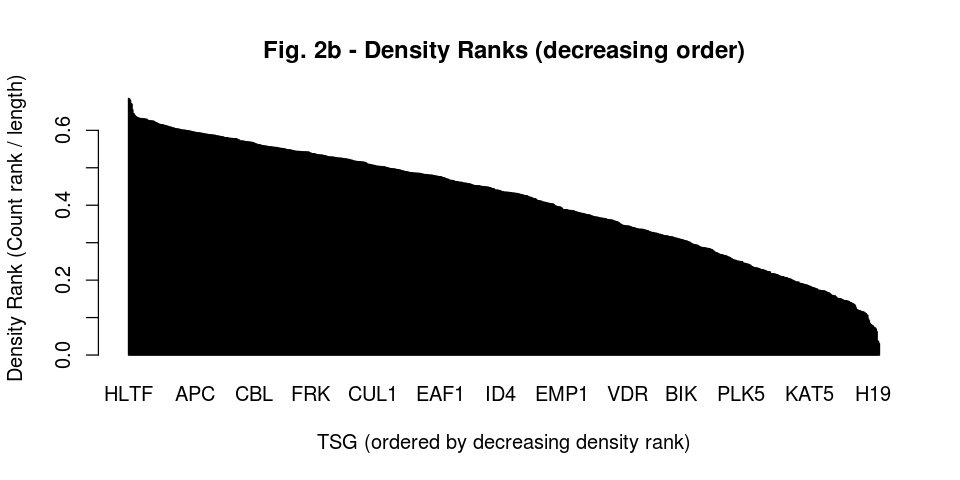

In [56]:
barplot(rank_den[order(-rank_den)],ylab="Density Rank (Count rank / length)",xlab="TSG (ordered by decreasing density rank)",col="black")
title("Fig. 2b - Density Ranks (decreasing order)")
options(repr.plot.width=8, repr.plot.height=4)

#### Zoom in to first 15 TSGs 

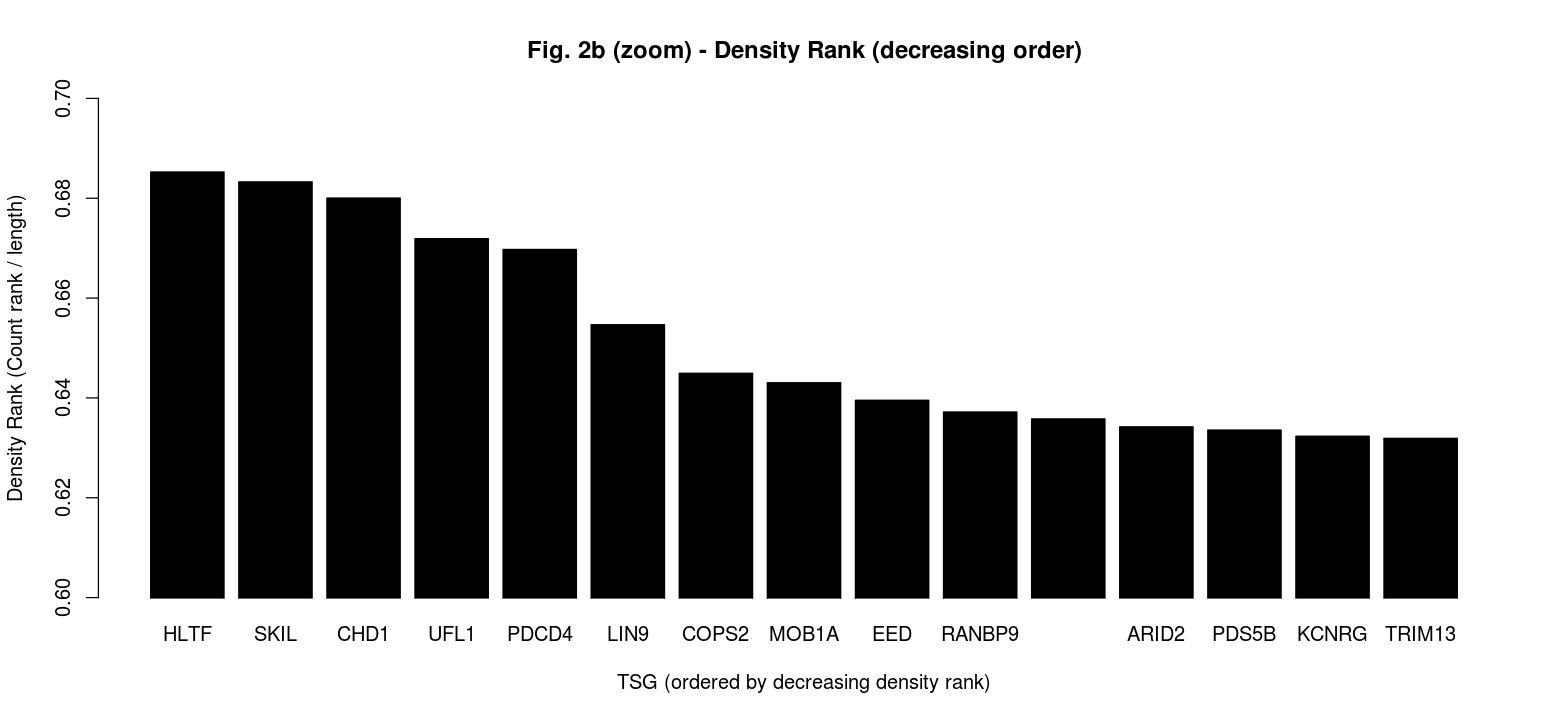

In [5]:
tmp <- rank_den[order(-rank_den)]

barplot(tmp[1:15],ylab="Density Rank (Count rank / length)",xlab="TSG (ordered by decreasing density rank)",col="black",ylim=c(0.6,.7),xpd=FALSE)
title("Fig. 2b (zoom) - Density Rank (decreasing order)")
options(repr.plot.width=13, repr.plot.height=6)

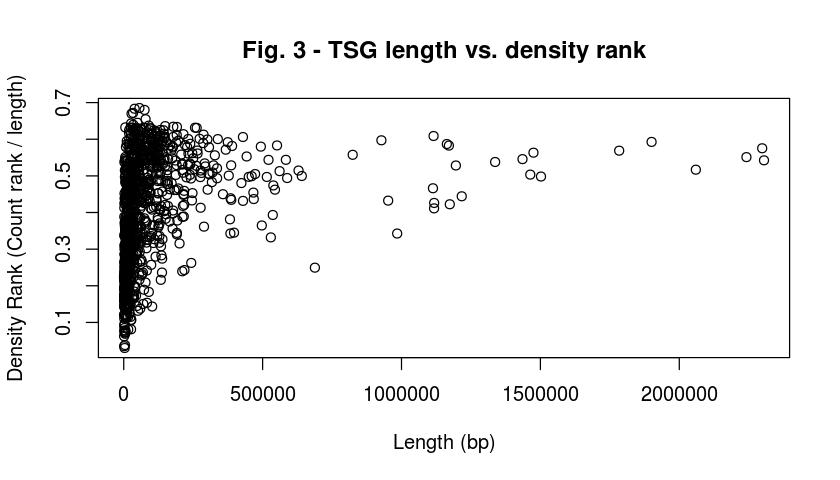

In [30]:
plot(tsgann$length,rank_den,ylab="Density Rank (Count rank / length)",xlab="Length (bp)")
title("Fig. 3 - TSG length vs. density rank")
options(repr.plot.width=7, repr.plot.height=4)

In [45]:
cat('Top 6 TSG count ranks')
nsites <- rowSums(tsg_counts_enrich)
tmp <- nsites[1:6]
tmp[order(-tmp)]

Top 6 TSG count ranks

PTPRD CNTNAP2     DMD   LRP1B   CSMD1  CTNNA3 
1322392 1250348 1235688 1126277 1064584 1014559

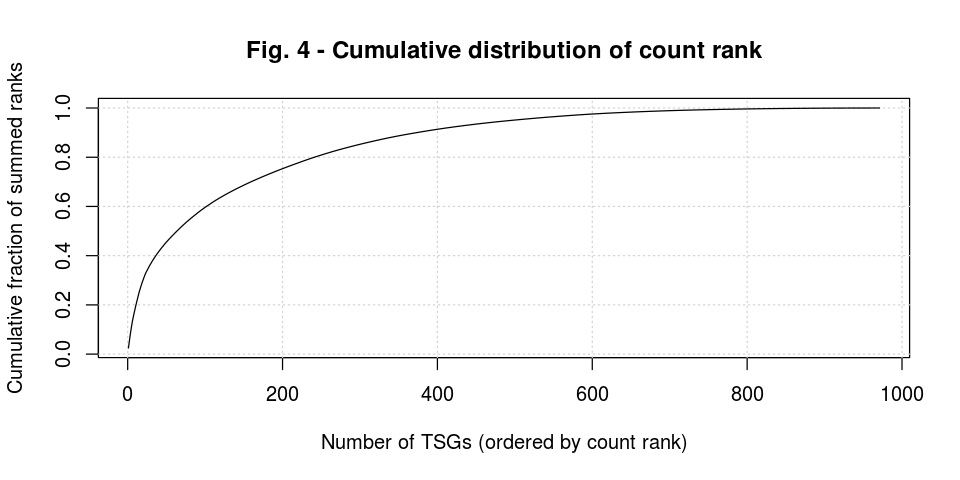

In [54]:
fracOfTotalSites <- nsites/sum(nsites)
fracOfTotalSites <- fracOfTotalSites[order(-fracOfTotalSites)]
cumuSum <- cumsum(fracOfTotalSites)
options(repr.plot.width=8, repr.plot.height=4)
plot(cumuSum,type="n",xlab="Number of TSGs (ordered by count rank)",ylab="Cumulative fraction of summed ranks")
grid()
lines(cumuSum)
title("Fig. 4 - Cumulative distribution of count rank")

# Analysis below is still in progress


In the analysis below, we map the density of endonuclease sites over the sequence of the PTPRD gene using a moving average method.

First, we compute the coordinates of each EN site in the gene, and its Snap-Velcro state.

In [186]:
PTPRD <- tsgs[[2]]
tmp<- mapSeq_SV(PTPRD)

In [187]:
en_movingav <- function(sequence) {
    halfWin <- 100000
    step <- 1000
    en_signal <- matrix(nrow=floor(length(sequence)/step),ncol=4)
    x_vals <- array(0,dim=c(1,floor(length(sequence)/step)))
    i<-halfWin+1
    j<-1
    while (i+halfWin < length(sequence)) {
        tmp_s   <- inrange(tmp$insites[tmp$ict[which(!is.na(tmp$ict[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$ict[which(!is.na(tmp$ict[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,1]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$icl[which(!is.na(tmp$icl[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$icl[which(!is.na(tmp$icl[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,2]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$iot[which(!is.na(tmp$iot[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$iot[which(!is.na(tmp$iot[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,3]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        tmp_s   <- inrange(tmp$insites[tmp$iol[which(!is.na(tmp$iol[,1])),1],1],i-halfWin,i+halfWin)
        tmp_ns  <- inrange(tmp$insites[tmp$iol[which(!is.na(tmp$iol[,2])),2],2],i-halfWin,i+halfWin)
        en_signal[j,4]<-length(which(tmp_s==TRUE)) + length(which(tmp_ns==TRUE))
        x_vals[j] = i
        i <- i+step
        j<-j+1
    }
    return(list(en_signal,x_vals))
}
ptm <- proc.time()
enSig <- en_movingav(PTPRD)
proc.time() - ptm

In [ ]:
options(repr.plot.width=10, repr.plot.height=4)
matplot(t(enSig[[2]]),enSig[[1]][,1],type="n",xlab="Gene Coordinates",ylab="# CT EN sites / 100000 bp")
lines(enSig[[2]],enSig[[1]][,1])

We will use the GenomicFeatures library to create a data structure from the locally stored hg38 GFF3 file.

In [ ]:
txdb <- makeTxDbFromGFF("../Data/humangenome/Homo_sapiens.GRCh38.89.gff3")
exonsByGene <- exonsBy(txdb,by="gene")

In [ ]:
exonsByGene$PTPRD
ones = array(1,dim=c(length(PTPRD),1))
for (i in 1:length(exonsByGene$PTPRD)) {
    ones[start(exonsByGene$PTPRD)[i]:end(exonsByGene$PTPRD)[i]]=mean(enSig[[1]][,1])
}
plot(ones)